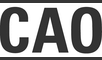

# CAO POINTS ANALYSIS

## Fundmentals of Data Analysis Assessment, Winter 21/22

## Michelle O'Connor, Student ID G00398975

***

### Table of Contents

* [CAO](##CAO)   
    * [Background](#CAO_background)
    * [Libraries and packages](#libraries)
    * [CAO Points format](#caopoints)   
    * [2019 Points assumption](#2019points)    
    * [Date and Time stamp](#date)   
* [2021 Points](#2021)
    * [CAO URL & save original dataset](#url)
    * [Select lines](#selectlines)
    * [Data Cleaning](#datacleaning1) 
    * [Data Types](#datatypes1)
    * [Save Clean data](#savecleandata1) 
* [2020 Points](#2020)
    * [Save original dataset](#save)
    * [Load Spreadsheet](#load)
    * [Course Levels](#levels)
    * [Data Cleaning](#datacleaning2) 
    * [Data Types](#datatypes2)
    * [Save Clean data](#savecleandata2)   
* [2019 Points](#2019)
    * [Download steps](#download)
    * [Data Cleaning](#datacleaning3) 
    * [Data Types](#datatypes3)
    * [Save Clean data](#savecleandata3) 
* [Concat & Join](#concat)
    * [Creating the dataset](#creating)
    * [Join to the points](#join)
    * [Complete R1 points dataset](#completer1) 
* [Points analysis](#points)
    * [Overall](#overall)  
    * [By college](#bycollege)  
    * [By college course](#bycollegecourse)  
* [Conclusion](#conclusion)
* [References](#references)  



## CAO <a name="CAO"></a>

***

### CAO Background <a name="CAO_background"></a>

Students applying for admission to third level education courses in Ireland apply to the CAO rather than to individual educational institutions such as colleges and universities. The CAO then offers places to students who meet the minimum requirements for a course for which they have applied. If for a particular course there are more qualified applicants than available places, the CAO makes offers to those applicants with the highest score in the CAO points system. If students do not accepts offers, or later decline them because they receive an offer for another course, the CAO makes further offers until all of the places have been filled or until the offer season closes.[1]  

### Import required libraries and packages <a name="libraries"></a>

In [1]:
# Convenient HTTP requests
import requests as rq

# Regular expressions
import re

# Dates and times
import datetime as dt

# Data frames
import pandas as pd

# To access a URL from python and downloading 
import urllib.request as urlrq

# Arrays
import numpy as np

# Plotting and visuals
import matplotlib.pyplot as plt

# Plotting and visuals
import seaborn as sns

### CAO Points Format <a name="caopoints"></a>

The CAO each year publish the points required for undergraduate courses in Irish Higher Education Institutions (HEIs).  

In this notebook, we will load the 2021, 2020 & 2019 points into one pandas dataframe and publish a detailed comparsion of the Level 8 courses showing the points activity over the 3 years. 

Each year comes in a different format :   

- 2021 will be downloaded via HTML [Click here to go directly to the 2021 points webpage](https://www.cao.ie/index.php?page=points&p=2021&bb=points)    

- 2020 will be downloaded via XLSX (Excel)
[Click here to go directly to the 2020 points webpage](https://www.cao.ie/index.php?page=points&p=2020&bb=points)    

- 2019 will be downloaded via PDF
[Click here to go directly to the 2019 points webpage](https://www.cao.ie/index.php?page=points&p=2019&bb=points)        

### 2019 Points Assumption <a name="2019points"></a>

Both 2021 & 2020 have round 1 and round 2 data.

For data more than 2 years old, e.g. 2019 points, the CAO website lists only the EOS points (Final points for which the course was offered at) and the Mid points (the points midway between the highest offer and the lowest offer). For the purposes of this analysis, I will use the 2019 EOS points as Round 1 points for that year. 

### Date and Time stamp <a name="date"></a>

Best practice when downloading data from the internet is to store a copy of the original data downloaded for verison control. At any stage the owner of the website may alter the data, if this happens you will have your own master copy of the data which you can reference at any time.  

One common practice is to date and timestamp the file as you save it. The below code will date and timestamp the files as I download them. 

In [2]:
# Get the current date and time
now = dt.datetime.now()

# Format as a string
nowstr = now.strftime('%Y%m%d_%H%M%S')

<br>

## 2021 Points  <a name="2021"></a>

***

### Fetch the CAO URL and save the original data set <a name="url"></a>


In [3]:
# Fetch the CAO points URL.
resp = rq.get('http://www2.cao.ie/points/l8.php')
# Check to response, if http code 200 means it is ok, however if you receive 404 then you have an error
resp

<Response [200]>

In [4]:
# Create a file path for the original data inlcuding a date & timestamp
pathhtml = 'data/cao2021_' + nowstr + '.html'

<br>

**Error on server**

Technically, the server says we should decode as per:
```
Content-Type: text/html; charset=iso-8859-1
```
However, one line uses \x96 which isn't defined in iso-8859-1.
<br>Therefore we use the similar decoding standard cp1252, which is very similar but includes #x96.

In [5]:
# The server uses the wrong encoding, fix it
original_encoding = resp.encoding
# Change to cp1252
resp.encoding = 'cp1252'

In [6]:
# Save the original html file
with open (pathhtml, 'w') as f:
    f.write(resp.text)

<br>

### Use regular expressions to select lines we want <a name="selectlines"></a>


In [7]:
# Compile the regular expression for matching lines
# [A-Z]{2} - Will select rows that start with two letters
# [0-9]{3} - Will select rows that then have 3 numbers after the 2 letters
# (.*) - and then this is a gotcha to cover everything else on the rows that start with 2 letters and 3 numbers
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')

<br>

### Loop through the lines of the response


Use regular expression to extract the lines we need

In [8]:
def points_to_array(s):
    portfolio = ''
    if s[0] == '#':
        portfolio = '#'
    random = ''
    if s[-1] == '*':
        random = '*'
    points = ''
    for i in s:
        if i.isdigit():
            points = points + i
    return [points, portfolio, random]

In [9]:
# Once we extract the rows we need, we need to save a csv verison of the data
# The file path for the csv file
path2021 = 'data/cao2021_csv_' + nowstr + '.csv'

In [10]:
# Keep track of how many courses we process 
no_lines = 0

# Open the csv file for writing
with open (path2021, 'w') as f:
    # Write a header row.
    f.write(','.join(['code','title','pointsR1','pointsR2']) + '\n')
    # Loop through lines of the respone
    for line in resp.iter_lines():
        # Decode the line, changed from ISO-8859-1 to cp1252
        # as one line uses \x96 which isn't defined in iso-8859-1
        dline = line.decode('cp1252')
        # Match only the lines representing courses
        if re_course.fullmatch(dline):
            # Add one to the lines counter
            no_lines = no_lines + 1
            # The course code
            course_code = dline[:5]
            # print(course_code)
            # The course title
            course_title = dline[7:57].strip()
            # Round one points
            course_points = re.split(' +', dline[60:])
            if len(course_points) !=2:
                # print(f"'{course_code} {course_points}'")
                course_points = course_points[:2]
            # Join the fields using a comma
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            # Rejoin the substrings with commas in between
            f.write(','.join(linesplit) + '\n')

# Print the total number of processed lines
print(f"Total number of lines is {no_lines}.")

Total number of lines is 949.


<br>

**NB:** It was verified as of 24th Nov 2021 that there was 949 courses exactly in the CAO 2021 point list

In [11]:
df2021 = pd.read_csv(path2021, encoding='cp1252')

In [12]:
list(df2021.columns)

['code', 'title', 'pointsR1', 'pointsR2']

In [13]:
# Take a quick look at the data to check 
df2021

,code,title,pointsR1,pointsR2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
...,...,...,...,...
944,WD211,Creative Computing,270,NaN
945,WD212,Recreation and Sport Management,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,230,230
947,WD231,Early Childhood Care and Education,266,NaN


### Data cleaning <a name="datacleaning1"></a>

Some rows have more than numbers in the points column, for example the '*', '#' and 'AQA' are appearing on some rows. 

In [14]:
display(df2021.iloc[842])

code                                                    MH801
title       Early Childhood - Teaching and Learning (part-...
pointsR1                                                  AQA
pointsR2                                                  AQA
Name: 842, dtype: object

In [15]:
# remove * & # characters [2]
df2021 = df2021.replace('[*,#]', '', regex = True)

In [16]:
# remove AQA characters
df2021 = df2021.replace('AQA', '', regex = True)

In [17]:
# Show row 842 after removing the non numerical characters
display(df2021.iloc[842])

code                                                    MH801
title       Early Childhood - Teaching and Learning (part-...
pointsR1                                                     
pointsR2                                                     
Name: 842, dtype: object

### Data types <a name="datatypes1"></a>

We will be comparing the points data for each year. In order to compare points data, the data type will need to be float or integer.  
Let's check the data types

In [18]:
# Check the data types
df2021.dtypes

code        object
title       object
pointsR1    object
pointsR2    object
dtype: object

In [19]:
# change the points columns from object to float [3]
df2021[['pointsR1','pointsR2']]= df2021[['pointsR1','pointsR2']].apply(pd.to_numeric)

In [20]:
df2021.dtypes

code         object
title        object
pointsR1    float64
pointsR2    float64
dtype: object

### Save clean data <a name="savecleandata1"></a>

Now that we have cleaned the 2021 data, I'll save a copy of the data

In [21]:
# Create a file path for the pandas data
path2021clean = 'data/cao2021clean_' + nowstr + '.csv'

In [22]:
# Save pandas data frame to disk
df2021.to_csv(path2021clean) 

<br>

## 2020 Points <a name="2020"></a>


***

I will download the 2020 points from an xlsx filem the link to the file is listed below:

In [23]:
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

<br>

### Save original 2020 dataset <a name="save"></a>


In [24]:
# Create a file path for the original data
pathxlsx = 'data/cao2020_' + nowstr + '.xlsx'

In [25]:
# Save original file to disk
urlrq.urlretrieve(url2020, pathxlsx)

('data/cao2020_20220102_233224.xlsx',
 <http.client.HTTPMessage at 0x1c37953eee0>)

<br>

### Load Spreadsheet using pandas <a name="load"></a>


In [26]:
# Download and parse the excel spreadsheet
df2020 = pd.read_excel(url2020, skiprows=10)

In [27]:
# Take a look at the dataset
df2020

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Spot check random row
df2020.iloc[1463]

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Mechanical and Manufacturing Engineering
COURSE CODE2                                                           WD230
R1 POINTS                                                                253
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      253
EOS Random *                                                             NaN
EOS Mid-point                                                            369
LEVEL                                                                      8
HEI                                        Waterford Institute of Technology
Test/Interview #                                                         NaN

In [29]:
# Create a file path for the pandas data
path2020 = 'data/cao2020_' + nowstr + '.csv'

In [30]:
# Save pandas data frame to disk
df2020.to_csv(path2020) 

In [31]:
# Check shape of original dataset
df2020.shape

(1464, 23)

### Course level <a name="levels"></a>

From reviewing the data load, I can see we have Level, 6, 7 & 8 courses listed. The analysis I am doing is only on Level 8 courses so I need only select the courses that meet this criteria. 

In [32]:
# Create a new dataframe with courses where the level is higher than 7 [4]
df2020new = df2020.loc[df2020["LEVEL"] > 7]
# Check shape of dataset with just level 8 courses
df2020new.shape

(1027, 23)

In [33]:
list(df2020new.columns)

['CATEGORY (i.e.ISCED description)',
 'COURSE TITLE',
 'COURSE CODE2',
 'R1 POINTS',
 'R1 Random *',
 'R2 POINTS',
 'R2 Random*',
 'EOS',
 'EOS Random *',
 'EOS Mid-point',
 'LEVEL',
 'HEI',
 'Test/Interview #',
 'avp',
 'v',
 'Column1',
 'Column2',
 'Column3',
 'Column4',
 'Column5',
 'Column6',
 'Column7',
 'Column8']

 ### Data Cleaning <a name="datacleaning2"></a>

Some rows have more than numbers in the points column, for example the *, # and AQA are appearing on some rows.

In [34]:
# remove +mat characters
# df2019 = df2019.replace('[+mat]', '')
df2020new = df2020new.replace(to_replace ="#+matric",value ='')

In [35]:
# remove AQA characters [2]
df2020new = df2020new.replace(to_replace ="AQA",value ='')

In [36]:
# remove *, # characters [2]
df2020new = df2020new.replace('[*,#]', '', regex = True)

### Data types <a name="datatypes2"></a>

We will be comparing the points data for each year. In order to compare points data, the data type will need to be float or integer.
Let's check the data types

In [37]:
df2020new.dtypes

CATEGORY (i.e.ISCED description)     object
COURSE TITLE                         object
COURSE CODE2                         object
R1 POINTS                            object
R1 Random *                          object
R2 POINTS                            object
R2 Random*                           object
EOS                                  object
EOS Random *                         object
EOS Mid-point                        object
LEVEL                                 int64
HEI                                  object
Test/Interview #                     object
avp                                  object
v                                    object
Column1                             float64
Column2                             float64
Column3                             float64
Column4                             float64
Column5                             float64
Column6                             float64
Column7                             float64
Column8                         

In [38]:
# change the points columns from object to float [3]
df2020new[['R1 POINTS','R2 POINTS']] = df2020new[['R1 POINTS','R2 POINTS']].apply(pd.to_numeric)

In [39]:
df2020new.dtypes

CATEGORY (i.e.ISCED description)     object
COURSE TITLE                         object
COURSE CODE2                         object
R1 POINTS                           float64
R1 Random *                          object
R2 POINTS                           float64
R2 Random*                           object
EOS                                  object
EOS Random *                         object
EOS Mid-point                        object
LEVEL                                 int64
HEI                                  object
Test/Interview #                     object
avp                                  object
v                                    object
Column1                             float64
Column2                             float64
Column3                             float64
Column4                             float64
Column5                             float64
Column6                             float64
Column7                             float64
Column8                         

### Save clean data <a name="savecleandata2"></a>

Now that we have cleaned the 2021 data, I'll save a copy of the data

In [40]:
# Create a file path for the pandas data
path2020clean = 'data/cao2020clean_' + nowstr + '.csv'

In [41]:
# Save pandas data frame to disk
df2020new.to_csv(path2020clean) 

<br>

## 2019 Points <a name="2019"></a>

***

Another format that data is available on the internet is on PDFs.  
The 2019 points are available in this format [2019 points PDF link](http://www2.cao.ie/points/lvl8_19.pdf)     

### Download steps <a name="download"></a>

1. Download original pdf file.
2. Open original pdf file in Microsoft Word.
3. Save Microsoft Word's converted PDF in docx format.
4. Re-save Word document for editing.
5. Delete headers and footers.
6. Delete preamble on page 1.
7. Select all and copy.
8. Paste into Notepad ++.
9. Remove HEI name headings and paste onto each course line. 
10. Delete blank lines.
11. Replace double tab characters with a single. 
12. Deleted tab character at end of line 308. 
13. Change backticks to apostrophes.

In [42]:
df2019 = pd.read_csv('data/cao2019_20211109_edited.csv', header=0, sep='\t')

In [43]:
# take a look at the data
df2019

,HEI,Course Code,INSTITUTION and COURSE,EOS,Mid
0,Athlone Institute of Technology,AL801,Software Design with Virtual Reality and Gaming,304,328.0
1,Athlone Institute of Technology,AL802,Software Design with Cloud Computing,301,306.0
2,Athlone Institute of Technology,AL803,Software Design with Mobile Apps and Connected...,309,337.0
3,Athlone Institute of Technology,AL805,Network Management and Cloud Infrastructure,329,442.0
4,Athlone Institute of Technology,AL810,Quantity Surveying,307,349.0
...,...,...,...,...,...
925,Waterford Institute of Technology,WD200,Arts (options),221,296.0
926,Waterford Institute of Technology,WD210,Software Systems Development,271,329.0
927,Waterford Institute of Technology,WD211,Creative Computing,275,322.0
928,Waterford Institute of Technology,WD212,Recreation and Sport Management,274,311.0


In [44]:
# Create a file path for the pandas data
path2019 = 'data/cao2019_' + nowstr + '.csv'

In [45]:
# Save pandas data frame to disk
df2019.to_csv(path2019) 

 ### Data Cleaning <a name="datacleaning3"></a>

In [46]:
# remove +mat characters [2]
df2019 = df2019.replace(to_replace ="\+mat",value = '0', regex = True)

In [47]:
# remove *, # characters [2]
df2019 = df2019.replace('[*,#]', '', regex = True)

### Data types <a name="datatypes3"></a>

Similar to the 2021 & 2020, since we will be comparing the points data for each year we need the data type to be a float or integer. Let's check the data types

In [48]:
df2019.dtypes

HEI                        object
Course Code                object
INSTITUTION and COURSE     object
EOS                        object
Mid                       float64
dtype: object

In [49]:
# change the points columns from object to float [3]
df2019[['EOS','Mid']] = df2019[['EOS','Mid']].apply(pd.to_numeric)

In [50]:
df2019.dtypes

HEI                        object
Course Code                object
INSTITUTION and COURSE     object
EOS                       float64
Mid                       float64
dtype: object

### Save clean data <a name="savecleandata3"></a>

In [51]:
# Create a file path for the pandas data
path2019a = 'data/cao2019a_' + nowstr + '.csv'

In [52]:
# Save pandas data frame to disk
df2019.to_csv(path2019a) 

<br>

##  Concat and join <a name="concat"></a>

***

Now that we have extracted the data by year, we will need to concatenate and join the data together before we can begin analysis. 

### Creating the dataset with all courses listed from 2019 to 2021 <a name="creating"></a>

#### 1. List the 2021 courses

In [53]:
courses2021 = df2021[['code', 'title']]
courses2021

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
944,WD211,Creative Computing
945,WD212,Recreation and Sport Management
946,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


#### 2. List the 2020 courses

In [54]:
courses2020 = df2020new[['COURSE CODE2', 'COURSE TITLE']]
courses2020.columns = ['code', 'title']
courses2020

,code,title
0,AC120,International Business
1,AC137,Liberal Arts
2,AD101,First Year Art & Design (Common Entryportfolio)
3,AD102,Graphic Design and Moving Image Design (portfo...
4,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
1455,WD200,Arts (options)
1460,WD210,Software Systems Development
1461,WD211,Creative Computing
1462,WD212,Recreation and Sport Management


#### 3. List the 2019 courses

In [55]:
courses2019 = df2019[['Course Code', 'INSTITUTION and COURSE']]
courses2019.columns = ['code', 'title']
courses2019

,code,title
0,AL801,Software Design with Virtual Reality and Gaming
1,AL802,Software Design with Cloud Computing
2,AL803,Software Design with Mobile Apps and Connected...
3,AL805,Network Management and Cloud Infrastructure
4,AL810,Quantity Surveying
...,...,...
925,WD200,Arts (options)
926,WD210,Software Systems Development
927,WD211,Creative Computing
928,WD212,Recreation and Sport Management


#### 4. Combine together

In [56]:
allcourses = pd.concat([courses2021, courses2020, courses2019], ignore_index=True)
allcourses

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
2901,WD200,Arts (options)
2902,WD210,Software Systems Development
2903,WD211,Creative Computing
2904,WD212,Recreation and Sport Management


#### 5.Check for duplication and remove duplicated rows

In [57]:
# Checks dataframe for duplicated rows
allcourses.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2901     True
2902     True
2903     True
2904     True
2905     True
Length: 2906, dtype: bool

In [58]:
# An alternative would be to sort it on the course code
allcourses.sort_values('code')

,code,title
175,AC120,International Business
2144,AC120,International Business
949,AC120,International Business
176,AC137,Liberal Arts
2145,AC137,Liberal Arts
...,...,...
1975,WD230,Mechanical and Manufacturing Engineering
946,WD230,Mechanical and Manufacturing Engineering
2905,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


In [59]:
# Finds duplicates based on the course code
allcourses[allcourses.duplicated(subset=['code'])]

,code,title
949,AC120,International Business
950,AC137,Liberal Arts
951,AD101,First Year Art & Design (Common Entryportfolio)
952,AD102,Graphic Design and Moving Image Design (portfo...
953,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
2901,WD200,Arts (options)
2902,WD210,Software Systems Development
2903,WD211,Creative Computing
2904,WD212,Recreation and Sport Management


In [60]:
# Returns a copy of the data frame with the duplicates removed - based only on code
allcourses.drop_duplicates(subset=['code'], inplace=True, ignore_index=True)
allcourses

,code,title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
1209,SG441,Environmental Science
1210,SG446,Applied Archaeology
1211,TL803,Music Technology
1212,TL812,Computing with Digital Media


####  6.Save a copy of data

In [61]:
# Create a file path for the pandas data
dfallcourses = allcourses
pathallcourses = 'data/allcourses_' + nowstr + '.csv'

In [62]:
# Save pandas data frame to disk before removing the duplicated rows
dfallcourses.to_csv(pathallcourses) 

<br>

### Join to the points <a name="join"></a>

***

#### 1.Join in the 2021 R1 points

In [63]:
# Set the index to the code column and add in the points
df2021.set_index('code', inplace=True)
df2021.columns = ['title', 'points_r1_2021', 'points_r2_2021']
df2021

,title,points_r1_2021,points_r2_2021
code,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,NaN
AL802,Software Design in Artificial Intelligence for...,313.0,NaN
AL803,Software Design for Mobile Apps and Connected ...,350.0,NaN
AL805,Computer Engineering for Network Infrastructure,321.0,NaN
AL810,Quantity Surveying,328.0,NaN
...,...,...,...
WD211,Creative Computing,270.0,NaN
WD212,Recreation and Sport Management,262.0,NaN
WD230,Mechanical and Manufacturing Engineering,230.0,230.0


In [64]:
# Set the index to the code column
allcourses.set_index('code', inplace=True)
allcourses

,title
code,
AL801,Software Design for Virtual Reality and Gaming
AL802,Software Design in Artificial Intelligence for...
AL803,Software Design for Mobile Apps and Connected ...
AL805,Computer Engineering for Network Infrastructure
AL810,Quantity Surveying
...,...
SG441,Environmental Science
SG446,Applied Archaeology
TL803,Music Technology


In [65]:
# Join 2021 points to allcourses
allcourses = allcourses.join(df2021[['points_r1_2021']])
allcourses

,title,points_r1_2021
code,,
AL801,Software Design for Virtual Reality and Gaming,300.0
AL802,Software Design in Artificial Intelligence for...,313.0
AL803,Software Design for Mobile Apps and Connected ...,350.0
AL805,Computer Engineering for Network Infrastructure,321.0
AL810,Quantity Surveying,328.0
...,...,...
SG441,Environmental Science,NaN
SG446,Applied Archaeology,NaN
TL803,Music Technology,NaN


#### 2.Join in the 2020 R1 points

In [66]:
# Change the title of the Course code and R1 POINTS columns
df2020_r1 = df2020new[['COURSE CODE2', 'R1 POINTS']]
df2020_r1.columns = ['code', 'points_r1_2020']
df2020_r1

,code,points_r1_2020
0,AC120,209.0
1,AC137,252.0
2,AD101,NaN
3,AD102,NaN
4,AD103,NaN
...,...,...
1455,WD200,NaN
1460,WD210,279.0
1461,WD211,271.0
1462,WD212,270.0


In [67]:
# Set the index to the code column
df2020_r1.set_index('code', inplace=True)
df2020_r1

,points_r1_2020
code,
AC120,209.0
AC137,252.0
AD101,NaN
AD102,NaN
AD103,NaN
...,...
WD200,NaN
WD210,279.0
WD211,271.0


In [68]:
# Join 2020 points to allcourses
allcourses = allcourses.join(df2020_r1)
allcourses

,title,points_r1_2021,points_r1_2020
code,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,303.0
AL802,Software Design in Artificial Intelligence for...,313.0,332.0
AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0
AL805,Computer Engineering for Network Infrastructure,321.0,333.0
AL810,Quantity Surveying,328.0,319.0
...,...,...,...
SG441,Environmental Science,NaN,NaN
SG446,Applied Archaeology,NaN,NaN
TL803,Music Technology,NaN,NaN


#### 3.Join in the 2019 R1 points

As outlined in the CAO section, for data more than 2 years old, e.g. 2019 points, the CAO website lists only the EOS points (Final points for which the course was offered at) and the Mid points (the points midway between the highest offer and the lowest offer). For the purposes of this analysis, I will use the 2019 EOS points as Round 1 points for that year. 

In [69]:
# Change the title of the EOS column to points_r1_2019
df2019_r1 = df2019[['Course Code', 'EOS']]
df2019_r1.columns = ['code', 'points_r1_2019']
df2019_r1

,code,points_r1_2019
0,AL801,304.0
1,AL802,301.0
2,AL803,309.0
3,AL805,329.0
4,AL810,307.0
...,...,...
925,WD200,221.0
926,WD210,271.0
927,WD211,275.0
928,WD212,274.0


In [70]:
# Set the index to the code column
df2019_r1.set_index('code', inplace=True)
df2019_r1

,points_r1_2019
code,
AL801,304.0
AL802,301.0
AL803,309.0
AL805,329.0
AL810,307.0
...,...
WD200,221.0
WD210,271.0
WD211,275.0


In [71]:
# Join 2019 points to allcourses
allcourses = allcourses.join(df2019_r1)
allcourses

,title,points_r1_2021,points_r1_2020,points_r1_2019
code,,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,303.0,304.0
AL802,Software Design in Artificial Intelligence for...,313.0,332.0,301.0
AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0,309.0
AL805,Computer Engineering for Network Infrastructure,321.0,333.0,329.0
AL810,Quantity Surveying,328.0,319.0,307.0
...,...,...,...,...
SG441,Environmental Science,NaN,NaN,297.0
SG446,Applied Archaeology,NaN,NaN,289.0
TL803,Music Technology,NaN,NaN,264.0


### Complete round 1 points dataset <a name="completer1"></a>

#### Dataset with 2021, 2020, 2019 Round 1 points

I now have one dataset with the course code, course title, Points R1 2021, Points R1 2020 and Points R1 2019. 

In [72]:
allcourses

,title,points_r1_2021,points_r1_2020,points_r1_2019
code,,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,303.0,304.0
AL802,Software Design in Artificial Intelligence for...,313.0,332.0,301.0
AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0,309.0
AL805,Computer Engineering for Network Infrastructure,321.0,333.0,329.0
AL810,Quantity Surveying,328.0,319.0,307.0
...,...,...,...,...
SG441,Environmental Science,NaN,NaN,297.0
SG446,Applied Archaeology,NaN,NaN,289.0
TL803,Music Technology,NaN,NaN,264.0


####  Save a copy of data

In [73]:
# Create a file path for the pandas data
dfallround1 = allcourses
pathallround1 = 'data/allround1_' + nowstr + '.csv'

In [74]:
# Save pandas data frame to disk before removing the duplicated rows
dfallround1.to_csv(pathallround1) 

## Points analysis <a name="points"></a>
***

### Overall CAO points activity analysis <a name="overall"></a>

Courses can go up or down in points each year, to begin our analysis we need to calculate if they went up or down. 

In [75]:
# Create 3 new column showing the points difference between the 3 years 
# Column 1 21 vs 20
# Column 2 21 vs 19
# Column 3 20 vs 19
dfallround1['21vs20'] = dfallround1['points_r1_2021']-dfallround1['points_r1_2020']
dfallround1['21vs19'] = dfallround1['points_r1_2021']-dfallround1['points_r1_2019']
dfallround1['20vs19'] = dfallround1['points_r1_2020']-dfallround1['points_r1_2019']

#view DataFrame 
dfallround1

,title,points_r1_2021,points_r1_2020,points_r1_2019,21vs20,21vs19,20vs19
code,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,303.0,304.0,-3.0,-4.0,-1.0
AL802,Software Design in Artificial Intelligence for...,313.0,332.0,301.0,-19.0,12.0,31.0
AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0,309.0,13.0,41.0,28.0
AL805,Computer Engineering for Network Infrastructure,321.0,333.0,329.0,-12.0,-8.0,4.0
AL810,Quantity Surveying,328.0,319.0,307.0,9.0,21.0,12.0
...,...,...,...,...,...,...,...
SG441,Environmental Science,NaN,NaN,297.0,NaN,NaN,NaN
SG446,Applied Archaeology,NaN,NaN,289.0,NaN,NaN,NaN
TL803,Music Technology,NaN,NaN,264.0,NaN,NaN,NaN


In [76]:
# Convert NaNs to Integer [5]
dfallround1['21vs20'].astype("Int64")

code
AL801      -3
AL802     -19
AL803      13
AL805     -12
AL810       9
         ... 
SG441    <NA>
SG446    <NA>
TL803    <NA>
TL812    <NA>
WD148    <NA>
Name: 21vs20, Length: 1214, dtype: Int64

In [77]:
# Check the data types of each column
dfallround1.dtypes

title              object
points_r1_2021    float64
points_r1_2020    float64
points_r1_2019    float64
21vs20            float64
21vs19            float64
20vs19            float64
dtype: object

In [78]:
# Categorise the results based on if they increased, decrease 
# stayed the same or if the course only appeared in one year of the comparison [6]
rating21vs20 = []
for row in dfallround1['21vs20']:
    if row > 0.0 :    rating21vs20.append('Increase')
    elif row < 0.0:   rating21vs20.append('Decrease')   
    elif row == 0.0:  rating21vs20.append('No change')
    else:             rating21vs20.append('Course for 1 year only')

rating20vs19 = []
for row in dfallround1['20vs19']:
    if row > 0.0 :    rating20vs19.append('Increase')
    elif row < 0.0:   rating20vs19.append('Decrease')
    elif row == 0.0:  rating20vs19.append('No change')
    else:           rating20vs19.append('Course for 1 year only')

rating21vs19 = []
for row in dfallround1['21vs19']:
    if row > 0.0 :    rating21vs19.append('Increase')
    elif row < 0.0:   rating21vs19.append('Decrease')
    elif row == 0.0:  rating21vs19.append('No change')
    else:           rating21vs19.append('Course for 1 year only')


In [79]:
# Add the categorisation to the dataset
dfallround1['rating21vs20'] = rating21vs20
dfallround1['rating20vs19'] = rating20vs19
dfallround1['rating21vs19'] = rating21vs19
print(dfallround1) 

                                                   title  points_r1_2021  \
code                                                                       
AL801     Software Design for Virtual Reality and Gaming           300.0   
AL802  Software Design in Artificial Intelligence for...           313.0   
AL803  Software Design for Mobile Apps and Connected ...           350.0   
AL805    Computer Engineering for Network Infrastructure           321.0   
AL810                                 Quantity Surveying           328.0   
...                                                  ...             ...   
SG441                              Environmental Science             NaN   
SG446                                Applied Archaeology             NaN   
TL803                                   Music Technology             NaN   
TL812                       Computing with Digital Media             NaN   
WD148                                  Tourism Marketing             NaN   

       poin

In [80]:
# Create a file path for the pandas data
pathround1 = 'data/allround1_' + nowstr + '.csv'
# Save pandas data frame to disk
dfallround1.to_csv(pathround1)

In [81]:
# Count each category
dft = dfallround1['rating21vs20'].value_counts()
# See the results
dft

Increase                  623
Course for 1 year only    361
Decrease                  187
No change                  43
Name: rating21vs20, dtype: int64

In [82]:
# Count each category
rating21vs20_count = dfallround1['rating21vs20'].value_counts()
rating20vs19_count = dfallround1['rating20vs19'].value_counts()
rating21vs19_count = dfallround1['rating21vs19'].value_counts()

Text(0.5, 1.0, 'Overall course activity in 2021 vs 2020')

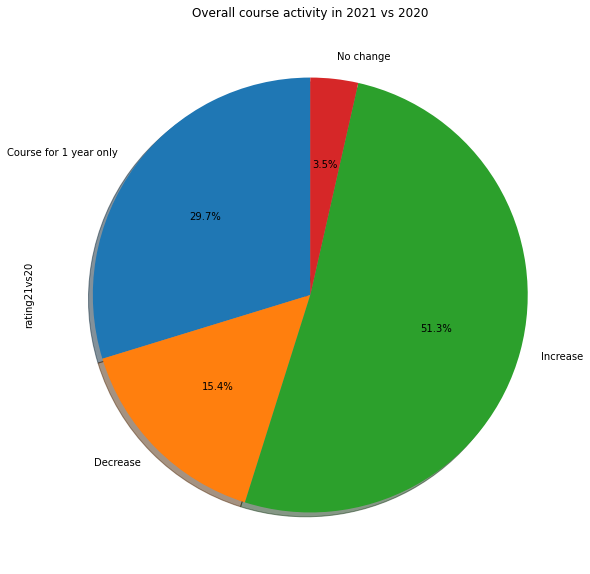

In [83]:
# Show the 2021 vs 2020 points change [7]
dfallround1.groupby('rating21vs20')['rating21vs20'].count().plot.pie(autopct='%1.1f%%', 
                                                 shadow=True, startangle=90, figsize=(14,10))
plt.title("Overall course activity in 2021 vs 2020")

This shows the following:  
51.3% increased in points  
15.4% decreased in points   
3.5% had no change in points  
29.7% represents where the course only existed in one of the years  

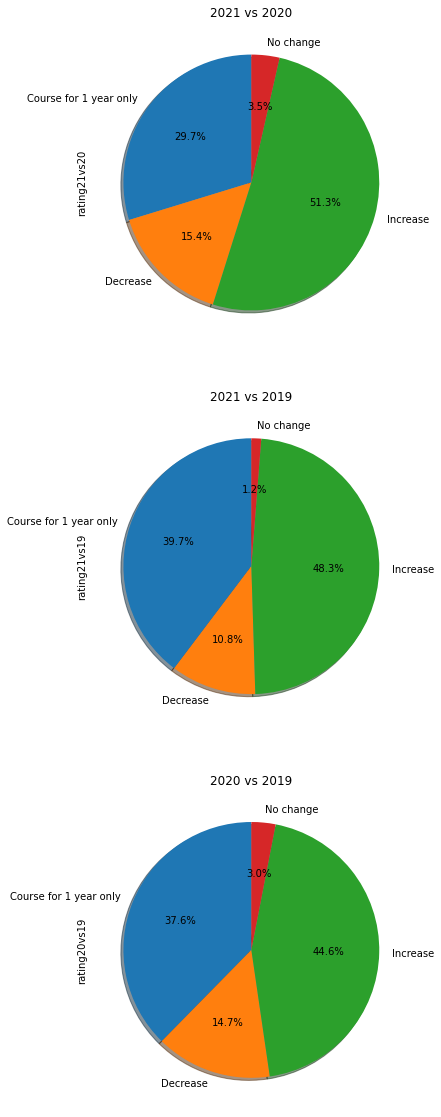

In [84]:
# I'll now plot all three years comparison together

plt.figure(figsize=(20, 20)) 
plt.subplot(3, 1, 1)
dfallround1.groupby('rating21vs20')['rating21vs20'].count().plot.pie(autopct='%1.1f%%', 
                                                 shadow=True, startangle=90)
plt.title("2021 vs 2020")

plt.subplot(3, 1, 2)
dfallround1.groupby('rating21vs19')['rating21vs19'].count().plot.pie(autopct='%1.1f%%', 
                                                 shadow=True, startangle=90)
plt.title("2021 vs 2019")


plt.subplot(3, 1, 3)
dfallround1.groupby('rating20vs19')['rating20vs19'].count().plot.pie(autopct='%1.1f%%', 
                                                 shadow=True, startangle=90)
plt.title('2020 vs 2019')
plt.show()

 ### R1 points activity analysis by college <a name="bycollege"></a>

In [85]:
# Enter the college choice [8]
college_choice = 'CR'

In [86]:
# Create a dataframe for the college choice
dfbycollegecode = dfallround1.filter(like = college_choice, axis=0)
dfbycollegecode

,title,points_r1_2021,points_r1_2020,points_r1_2019,21vs20,21vs19,20vs19,rating21vs20,rating20vs19,rating21vs19
code,,,,,,,,,,
CR105,Chemical and Biopharmaceutical Engineering,443.0,443.0,432.0,0.0,11.0,11.0,No change,Increase,Increase
CR106,Software Development,431.0,411.0,351.0,20.0,80.0,60.0,Increase,Increase,Increase
CR108,Mechanical Engineering,434.0,434.0,425.0,0.0,9.0,9.0,No change,Increase,Increase
CR109,Structural Engineering,396.0,394.0,341.0,2.0,55.0,53.0,Increase,Increase,Increase
CR110,Automotive Business Management and Technology,336.0,311.0,318.0,25.0,18.0,-7.0,Increase,Decrease,Increase
CR112,Creative Digital Media at CIT Crawford College of,390.0,361.0,335.0,29.0,55.0,26.0,Increase,Increase,Increase
CR116,Computer Systems,365.0,332.0,318.0,33.0,47.0,14.0,Increase,Increase,Increase
CR121,Music at CIT Cork School of Music,904.0,868.0,633.0,36.0,271.0,235.0,Increase,Increase,Increase
CR125,Popular Music at CIT Cork School of Music,1028.0,1088.0,972.0,-60.0,56.0,116.0,Decrease,Increase,Increase


In [87]:
# Count each category
rating21vs20bycollege_count = dfbycollegecode['rating21vs20'].value_counts()
rating20vs19bycollege_count = dfbycollegecode['rating20vs19'].value_counts()
rating21vs19bycollege_count = dfbycollegecode['rating21vs19'].value_counts()
rating21vs20bycollege_count

Increase                  25
Course for 1 year only    10
Decrease                   8
No change                  4
Name: rating21vs20, dtype: int64

Text(0.5, 1.0, 'Course activity by college in 2021 vs 2020 for college code - CR')

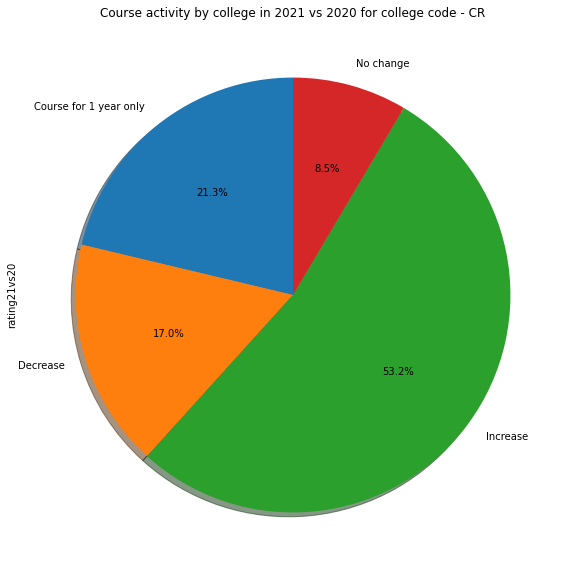

In [88]:
# Show the 2021 vs 2020 points change [7]
dfbycollegecode.groupby('rating21vs20')['rating21vs20'].count().plot.pie(autopct='%1.1f%%', 
                                                 shadow=True, startangle=90, figsize=(14,10))
plt.title("Course activity by college in 2021 vs 2020 for college code - " + college_choice)

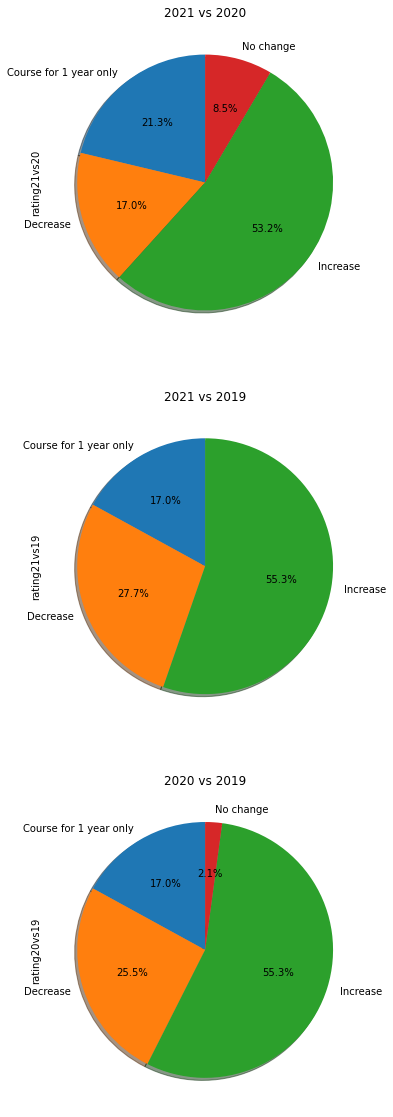

In [89]:
# I'll now plot all three years comparison together

plt.figure(figsize=(20, 20)) 
plt.subplot(3, 1, 1)
dfbycollegecode.groupby('rating21vs20')['rating21vs20'].count().plot.pie(autopct='%1.1f%%', 
                                                 shadow=True, startangle=90)
plt.title("2021 vs 2020")

plt.subplot(3, 1, 2)
dfbycollegecode.groupby('rating21vs19')['rating21vs19'].count().plot.pie(autopct='%1.1f%%', 
                                                 shadow=True, startangle=90)
plt.title("2021 vs 2019")


plt.subplot(3, 1, 3)
dfbycollegecode.groupby('rating20vs19')['rating20vs19'].count().plot.pie(autopct='%1.1f%%', 
                                                 shadow=True, startangle=90)
plt.title('2020 vs 2019')
plt.show()

 ### R1 points activity analysis by college course <a name="bycollegecourse"></a>

Select the course of your choice.

In [90]:
# Pick the course [8]
course_choice = 'AL802'

In [91]:
# Reset the index to have the code as a column of data [9]
coursechoicedf = allcourses.reset_index()
coursechoicedf

,code,title,points_r1_2021,points_r1_2020,points_r1_2019,21vs20,21vs19,20vs19,rating21vs20,rating20vs19,rating21vs19
0,AL801,Software Design for Virtual Reality and Gaming,300.0,303.0,304.0,-3.0,-4.0,-1.0,Decrease,Decrease,Decrease
1,AL802,Software Design in Artificial Intelligence for...,313.0,332.0,301.0,-19.0,12.0,31.0,Decrease,Increase,Increase
2,AL803,Software Design for Mobile Apps and Connected ...,350.0,337.0,309.0,13.0,41.0,28.0,Increase,Increase,Increase
3,AL805,Computer Engineering for Network Infrastructure,321.0,333.0,329.0,-12.0,-8.0,4.0,Decrease,Increase,Decrease
4,AL810,Quantity Surveying,328.0,319.0,307.0,9.0,21.0,12.0,Increase,Increase,Increase
...,...,...,...,...,...,...,...,...,...,...,...
1209,SG441,Environmental Science,NaN,NaN,297.0,NaN,NaN,NaN,Course for 1 year only,Course for 1 year only,Course for 1 year only
1210,SG446,Applied Archaeology,NaN,NaN,289.0,NaN,NaN,NaN,Course for 1 year only,Course for 1 year only,Course for 1 year only
1211,TL803,Music Technology,NaN,NaN,264.0,NaN,NaN,NaN,Course for 1 year only,Course for 1 year only,Course for 1 year only
1212,TL812,Computing with Digital Media,NaN,NaN,369.0,NaN,NaN,NaN,Course for 1 year only,Course for 1 year only,Course for 1 year only


In [92]:
# Select the columns needed [10]
coursechoicedf = coursechoicedf[["code","points_r1_2021", "points_r1_2020", "points_r1_2019"]]
coursechoicedf

,code,points_r1_2021,points_r1_2020,points_r1_2019
0,AL801,300.0,303.0,304.0
1,AL802,313.0,332.0,301.0
2,AL803,350.0,337.0,309.0
3,AL805,321.0,333.0,329.0
4,AL810,328.0,319.0,307.0
...,...,...,...,...
1209,SG441,NaN,NaN,297.0
1210,SG446,NaN,NaN,289.0
1211,TL803,NaN,NaN,264.0
1212,TL812,NaN,NaN,369.0


In [93]:
# Change order of columns [11]
coursechoicedf = coursechoicedf[['code', 'points_r1_2019', 'points_r1_2020', 'points_r1_2021']]
coursechoicedf

,code,points_r1_2019,points_r1_2020,points_r1_2021
0,AL801,304.0,303.0,300.0
1,AL802,301.0,332.0,313.0
2,AL803,309.0,337.0,350.0
3,AL805,329.0,333.0,321.0
4,AL810,307.0,319.0,328.0
...,...,...,...,...
1209,SG441,297.0,NaN,NaN
1210,SG446,289.0,NaN,NaN
1211,TL803,264.0,NaN,NaN
1212,TL812,369.0,NaN,NaN


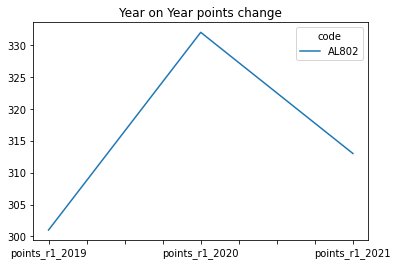

In [94]:
# Plot the change in points for selected course [12][13]
coursechoicedf = coursechoicedf.loc[coursechoicedf['code'] == course_choice]
coursechoicedf.set_index("code").T.plot()
plt.title("Year on Year points change")
plt.show()

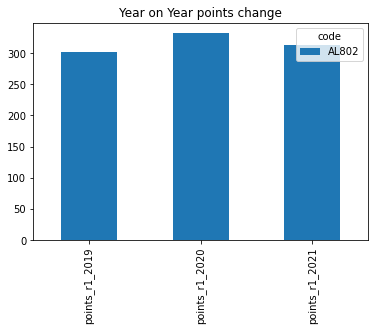

In [95]:
# To show as a bar chart
coursechoicedf.set_index("code").T.plot.bar()
plt.title("Year on Year points change")
plt.show()

***
### Conclusion <a name="conclusion"></a>

In the lecture videos for Fundamentals of Data analysis, Ian McLoughlin covered the topics of downloading the data from the 3 different formats (PDF, XLSX, and HTML) using the CAO data.  

Working on concatenating and joining the data, highlighted the need for clean data, for example consideration for column titles, special characters to ensure data could be joined.    
 
At the time of downloading the 2021 data, EOS information was not available for 2021. It was for this reason I made an assumption to use the 2019 EOS points as Round 1 points for that year. 

The comparison of the points year on year showed it a 3 different levels:  
1. Overall  
2. By college code  
3. By college course 


***
### References <a name="references"></a>

CAO website www.cao.ie  
Class lecture videos https://github.com/ianmcloughlin/cao-points/blob/main/cao-points-analysis.ipynb    

[1] https://en.wikipedia.org/wiki/Central_Applications_Office   
[2] https://www.geeksforgeeks.org/python-pandas-dataframe-replace/  
[3] https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html   
[4] https://www.shanelynn.ie/pandas-drop-delete-dataframe-rows-columns/    
[5] https://www.kite.com/python/answers/how-to-convert-a-pandas-dataframe-column-containing-nans-to-a-specific-type-in-python  
[6] https://www.projectpro.io/recipes/insert-new-column-based-on-condition-in-python  
[7] https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html   
[8] https://datatofish.com/filter-pandas-dataframe/  
[9] https://www.delftstack.com/howto/python-pandas/pandas-remove-index/     
[10] https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html   
[11] https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns   
[12] https://stackoverflow.com/questions/68285141/how-to-display-x-axis-from-pandas-dataframe-object-to-matplotlib-barchart  
[13] https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values  
